In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


# 0. Import Packages

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import ConnectionPatch

In [3]:
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold


/opt/conda/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [4]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# 1. Read Data

In [5]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
df_test  = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
df_sub = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

In [6]:
df_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [7]:
df_train.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [8]:
set(df_train.columns) - set(df_test.columns)

{'loan_status'}

In [9]:
df_sub.head()

,id,loan_status
0,58645,0.5
1,58646,0.5
2,58647,0.5
3,58648,0.5
4,58649,0.5


In [10]:
df_train = df_train.drop(columns=['id'])
df_test = df_test.drop(columns=['id'])

# 2. Data EDA

In [11]:
df_train.shape,df_test.shape

((58645, 12), (39098, 11))

In [12]:
df_train.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [13]:
df_test.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

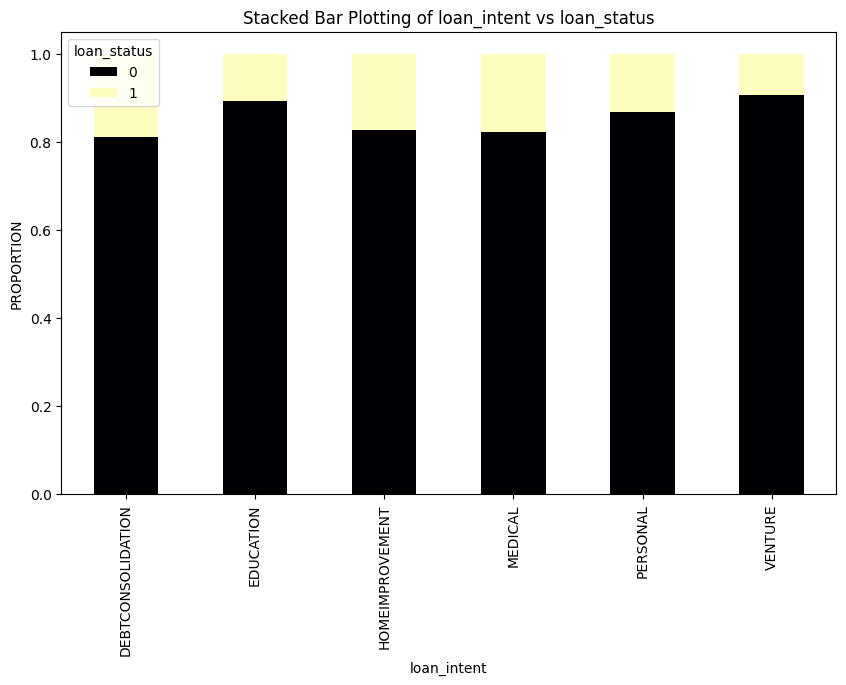

In [14]:
def stacked_bar_plot(df, feature, target='loan_status'):
    crosstab = pd.crosstab(df[feature], df[target], normalize='index')
    crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='magma')
    plt.title(f'Stacked Bar Plotting of {feature} vs {target}')
    plt.ylabel('PROPORTION')
    plt.show()
stacked_bar_plot(df_train, 'loan_intent')

In [15]:
y = df_train['loan_status'] 
df_train = df_train.drop(['loan_status'],axis=1)
X = df_train

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_train_data = df_train
scaled_test_data = df_test

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 4.9+ MB


In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.3+ MB


In [19]:
df_train.drop(["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"], axis=1, inplace=True)
df_test.drop(["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"], axis=1, inplace=True)

In [20]:
xgb_params = {
    'n_estimators': 600,
    'max_depth': 10,
    'learning_rate': 0.06,
    'random_state': 99,
    
    'eval_metric': 'auc'
}

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=99)

xgb_predictions = np.zeros(len(scaled_train_data))
xgb_true_labels = np.zeros(len(scaled_train_data))
xgb_test_predictions = np.zeros(len(scaled_test_data))

for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    X_train, X_val = scaled_train_data.iloc[train_idx], scaled_train_data.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    xgb_model = XGBClassifier(**xgb_params)

    xgb_model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=10,
                  verbose=100)
    xgb_fold_preds = xgb_model.predict_proba(X_val)[:, 1] 
    xgb_fold_test_preds = xgb_model.predict_proba(scaled_test_data)[:, 1]
    xgb_predictions[val_idx] = xgb_fold_preds
    xgb_true_labels[val_idx] = y_val
    xgb_test_predictions += xgb_fold_test_preds / n_splits

overall_auc_xgb = roc_auc_score(xgb_true_labels, xgb_predictions)
print("Overall AUC (XGBClassifier):", overall_auc_xgb)

[0]	validation_0-auc:0.92124	validation_1-auc:0.89991


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-auc:0.97608	validation_1-auc:0.92484
[147]	validation_0-auc:0.98244	validation_1-auc:0.92508
[0]	validation_0-auc:0.92129	validation_1-auc:0.90187


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-auc:0.97487	validation_1-auc:0.92696
[109]	validation_0-auc:0.97601	validation_1-auc:0.92687
[0]	validation_0-auc:0.92088	validation_1-auc:0.89966


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-auc:0.97428	validation_1-auc:0.92322
[159]	validation_0-auc:0.98080	validation_1-auc:0.92527
[0]	validation_0-auc:0.91833	validation_1-auc:0.91124


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-auc:0.97383	validation_1-auc:0.93296
[108]	validation_0-auc:0.97476	validation_1-auc:0.93310
[0]	validation_0-auc:0.92239	validation_1-auc:0.90515


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-auc:0.95951	validation_1-auc:0.91821
Overall AUC (XGBClassifier): 0.9238681348903743


# 99. Submission

In [21]:
df_sub['loan_status'] = [1 if x > 0.5 else 0 for x in xgb_test_predictions]
df_sub.head()

,id,loan_status
0,58645,1
1,58646,0
2,58647,1
3,58648,0
4,58649,0


In [22]:
df_sub.to_csv('submission.csv', index=False)